In [ ]:
!pip install keybert

In [ ]:
!pip install kagglehub

In [3]:
import os
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords, wordnet
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from collections import Counter

## Keywords extraction

In [ ]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# ===========================
# Load and Preprocess Dataset
# ===========================

# Download latest version
path = kagglehub.dataset_download("therohk/million-headlines")
# https://www.kaggle.com/datasets/therohk/million-headlines

# print("Path to dataset files:", path)

# Construct the file path to the CSV file
csv_file_path = os.path.join(path, "abcnews-date-text.csv")

# Load the dataset into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert 'publish_date' to datetime format for easy grouping
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')

# Create 'year_month' column to group by months
df['year_month'] = df['publish_date'].dt.to_period('M')

# ===========================
# Sampling (Reduce Dataset Size)
# ===========================

# **SAMPLE: Randomly select headlines per month**
# Adjust sample size: Too small (e.g., 10) makes trends unreliable, 100-500 is better
df = df.groupby('year_month').apply(lambda x: x.sample(min(len(x), 1000), random_state=24)).reset_index(drop=True)

# ===========================
# Stopwords
# ===========================

stop_words = set(stopwords.words('english'))

news_terms = {
    'breaking', 'news', 'update', 'updates', 'report', 'reports', 'reported', 'reporting',
    'latest', 'exclusive', 'exclusively', 'today', 'live', 'watch', 'watches', 'watched',
    'watching', 'listen', 'listens', 'listened', 'listening', 'revealed', 'reveals',
    'revealing', 'headline', 'headlines', 'concern', 'concerns', 'concerning', 'says'
}

australian_locations = {
    'australia', 'australian', 'australians', 'aust', 'austr', 'australi', 'austs', 'australis','ipswich', 'sydney', 'sydneys', 'nsw', 'aus', 'nz', 'brisbane', 'brisbanes', 'canberra', 'canberras', 'fiji','fijis' 'fijian', 'fijians', 'tonga',
    'melbourne', 'melbournes', 'adelaide', 'adelaides', 'queensland', 'queenslands', 'queenslanders', 'qld', 'perth', 'hobart', 'lanka', 'indonesia', 'indonesian', 'indonesians',
    'newcastle', 'kimberley', 'macquarie', 'darwin', 'victoria', 'vic', 'victorian', 'victorians', 'rockhampton', 'townsville',
    'mackay', 'tasmania', 'tasmanian', 'south', 'north', 'east', 'west', 'western', 'northern', 'southern', 'eastern',
    'territory', 'territories', 'coast', 'coastal', 'kilda', 'fremantle', 'creek', 'flinders', 'cairns', 'collingwood', 'gippsland',
    'goldcoast', 'sunshinecoast', 'wollongong', 'geelong', 'toowoomba', 'ballarat', 'tonga', 'tongan', 'tongans',
    'bendigo', 'launceston', 'bundaberg', 'burnie', 'devonport', 'broome', 'tasmanias', 'fitzroy',
    'valley', 'whitsundays', 'grafton', 'harbour', 'gladstone', 'tasmanians', 'zimbabwe',
    'tamworth', 'armidale', 'bathurst', 'orange', 'dubbo', 'wagga', 'mildura', 'kalgoorlie',
    'geraldton', 'bunbury', 'albany', 'lincoln', 'whyalla', 'shepparton', 'warrnambool', 'horsham',
    'devonport', 'burnie', 'katherine', 'karratha', 'esperance', 'geraldton', 'parramatta',
    'sydneysider', 'sydneysiders', 'melburnian', 'melburnians', 'brisbanite', 'brisbanites', 'perthite', 'perthites',
    'adelaidian', 'adelaideans', 'hobartian', 'hobartians', 'darwinian', 'darwinians', 'canberran', 'canberrans',
    'novocastrian', 'novocastrians', 'coaster', 'essendon',
    'wollongongite', 'wollongongites', 'geelongite', 'geelongites', 'cairnsian', 'cairnsians', 'townsvillian',
    'townsvillians', 'toowoomban', 'toowoombans', 'ballaratan', 'ballaratans', 'bendigonian', 'bendigonians',
    'launcestonian', 'launcestonians', 'mackayite', 'mackayites', 'rockhamptonite', 'rockhamptonites', 'bundabergian',
    'bundabergians', 'burnieite', 'burnieites', 'devonportian', 'devonportians', 'perths', 'zealand', 'zealands', 'new', 'austra'
}

political_terms = {
    'parliament', 'parliaments', 'parliamentary', 'government', 'governments', 'minister',
    'ministers', 'mp', 'mps', 'senator', 'senators', 'councillor', 'councillors',
    'council', 'councils', 'mayor', 'mayors', 'officer', 'officers', 'premier', 'premiers',
    'opposition', 'oppositions', 'policy', 'policies', 'election', 'campaign',
    'campaigns', 'liberal', 'liberals', 'trial', 'trials', 'appeal', 'appeals', 'detention',
    'jury', 'juries', 'warn', 'warns', 'warning', 'warnings', 'labor', 'greens', 'nationals',
    'senate', 'coalition', 'govt', 'govts', 'governmental', 'commonwealth', 'tribunal', 'rudds', 'turnbulls'
}
common_fillers = {
    'man', 'men', 'woman', 'women', 'people', 'person', 'persons', 'australian',
    'australians', 'aussie', 'aussies', 'australias', 'official', 'officials',
    'farmer', 'farmers', 'police', 'court', 'case', 'cases', 'public',
    'locals', 'local', 'national', 'nationals', 'traffic', 'kill', 'kills', 'killed',
    'killing', 'toll', 'tolls', 'hospital', 'hospitals', 'road', 'roads', 'victim',
}
others = {
    'crackdown', 'crackdowns', 'aboriginal', 'aboriginals', 'anzac', 'qantas',
    'cricket', 'cricketer', 'cricketers', 'ambulance', 'ambulances', 'rally',
    'rallies', 'shire', 'shires', 'queenslander', 'queenslanders', 'farm', 'farms',
    'rugby', 'crew', 'crews', 'coroner', 'coroners', 'geelong', 'kangaroo', 'kangaroos',
    'shark', 'sharks', 'wallaby', 'wallabies', 'ashes', 'howards', 'austrac', 'australa'
}

new_sw = list(news_terms.union(australian_locations, political_terms, common_fillers, others))
stop_words.update(new_sw)

In [ ]:
# ===========================
# Keyword Extraction (KeyBERT)
# ===========================

# Initialize KeyBERT
kw_model = KeyBERT()

# Function to extract keywords and their embeddings
def extract_keywords_and_embeddings(text):

    # Use CountVectorizer to generate candidate n-grams (both unigrams and bigrams)
    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=list(stop_words))
    vectorizer.fit([text])
    candidates = vectorizer.get_feature_names_out().tolist()

    # Extract embeddings for document and all candidate words
    doc_embeddings, word_embeddings = kw_model.extract_embeddings(text, vectorizer=vectorizer, keyphrase_ngram_range=(1, 2), stop_words=list(stop_words))

    # Extract keywords using precomputed embeddings
    keywords_with_scores = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 2),
        doc_embeddings=doc_embeddings,
        word_embeddings=word_embeddings,
        top_n=50,
        stop_words=list(stop_words)
    )

    # Extract only keywords (ignoring scores)
    keywords = [kw[0] for kw in keywords_with_scores]

    # Retrieve embeddings for the keywords
    keyword_embeddings = []
    for keyword in keywords:
      try:
          idx = candidates.index(keyword)
          keyword_embeddings.append(word_embeddings[idx])
      except ValueError:
          keyword_embeddings.append(None)

    return keywords, keyword_embeddings

# Update the grouped_df to use the cleaned headlines
grouped_df = df.groupby('year_month')['headline_text'].apply(', '.join).reset_index()

# Get the keywords and embeddings
grouped_df['keywords_and_embeddings'] = grouped_df['headline_text'].apply(extract_keywords_and_embeddings)

## Clustering

In [6]:
# Split the results into separate columns
grouped_df['keywords'] = grouped_df['keywords_and_embeddings'].apply(lambda x: x[0])  # Extract keywords
grouped_df['keywords_embeddings'] = grouped_df['keywords_and_embeddings'].apply(lambda x: x[1])  # Extract embeddings

# Flatten the keywords list for clustering
all_keywords = [kw for sublist in grouped_df['keywords'] for kw in sublist]

# Flatten the keywords embeddings list for clustering
keyword_embeddings = [emb for sublist in grouped_df['keywords_embeddings'] for emb in sublist]

In [18]:
# ===========================
# Semantic Clustering (HDBSCAN)
# ===========================
warnings.filterwarnings("ignore")

def modified_silhouette_score(X, labels):
    """
    Computes the silhouette score for clustering using cosine similarity.

    Parameters:
    - X: np.array of shape (n_samples, n_features), the embedding vectors.
    - labels: np.array of shape (n_samples,), the cluster labels.

    Returns:
    - float: The mean modified silhouette score.
    """
    unique_labels = set(labels) - {-1}  # Ignore noise (-1)
    if len(unique_labels) < 2:
        return 0  # Silhouette score is undefined if only one cluster

    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(X)

    s_values = []

    for i in range(len(X)):
        label = labels[i]
        if label == -1:  # Skip noise points
            continue

        # Get indices of points in the same cluster
        in_cluster = (labels == label)
        in_cluster[i] = False  # Exclude self

        # Compute a'(i) - average similarity within own cluster
        a_i = np.mean(sim_matrix[i, in_cluster]) if np.any(in_cluster) else 0

        # Compute b'(i) - max average similarity to another cluster
        b_i = -1  # Start with an invalid similarity
        for other_label in unique_labels:
            if other_label == label:
                continue  # Skip own cluster

            other_cluster = (labels == other_label)
            avg_sim_other_cluster = np.mean(sim_matrix[i, other_cluster]) if np.any(other_cluster) else 0
            b_i = max(b_i, avg_sim_other_cluster)

        # Compute the modified silhouette score for point i
        if a_i > b_i:
            s_i = 1 - (b_i / a_i)
        elif a_i < b_i:
            s_i = (a_i / b_i) - 1
        else:
            s_i = 0

        s_values.append(s_i)

    # Return mean silhouette score
    return np.mean(s_values) if s_values else 0


# Function to map keywords to topic labels
def map_keywords_to_topics(keywords, cluster_labels, keyword_cluster_map):
    """
    Maps a list of keywords to their corresponding topic labels based on a clustering result.

    Parameters:
    keywords (list): A list of keywords to be mapped.
    cluster_labels (dict): A dictionary mapping cluster indices to topic labels.
    keyword_cluster_map (dict): A dictionary mapping keywords to their assigned cluster index.

    Returns:
    list: A list of topic labels corresponding to the input keywords. If a keyword does not
          belong to a cluster, it is assigned "No Cluster". If a cluster exists but has no
          corresponding label, it is assigned "Unknown".
    """
    topics = []
    for kw in keywords:
        if kw in keyword_cluster_map and keyword_cluster_map[kw] != -1:
            cluster = keyword_cluster_map[kw]
            if cluster in cluster_labels:
                topics.append(cluster_labels[cluster])
            else:
                topics.append("Unknown")  # Assign "Unknown" if no label exists for the cluster
        else:
            topics.append("No Cluster")  # Handle keywords without a cluster label or noise
    return topics


def cluster_consistency(X, labels):
    """
    Computes the average intra-cluster distance to measure the consistency of clusters.

    Parameters:
    X (numpy.ndarray): A 2D array where each row represents a data point and each column represents a feature.
    labels (numpy.ndarray or list): A 1D array or list of cluster labels assigned to each data point.
                                    Noise points are assumed to be labeled as -1.

    Returns:
    float: The mean of the average intra-cluster distances, representing cluster consistency.
           Lower values indicate more compact clusters.
    """

    # Get the unique cluster labels, excluding the noise label (-1)
    unique_labels = set(labels) - {-1}

    # List to store average intra-cluster distances
    avg_dists = []

    # Iterate through each unique cluster
    for label in unique_labels:
        # Extract points belonging to the current cluster
        cluster_points = X[labels == label]

        # Compute the average pairwise distance within the cluster if it contains more than one point
        if len(cluster_points) > 1:
            intra_dists = pairwise_distances(cluster_points).mean()
            avg_dists.append(intra_dists)

    # Return the mean of the average intra-cluster distances
    return np.mean(avg_dists)


def representative_keyword_weighted(cluster_keywords, keyword_embeddings, all_keywords, weight_centrality=0.7, weight_frequency=0.3):
    """
    Given a list of keywords (which may include duplicates) for a cluster,
    returns the representative keyword based on a weighted combination of
    centrality (cosine similarity to the weighted centroid) and frequency.

    Parameters:
      - cluster_keywords: list of keywords in the cluster (e.g., ['vaccine', 'flu', 'covid', 'sars', ...])
      - keyword_embeddings: a numpy array of embeddings for each keyword in all_keywords,
                            with the same order as all_keywords.
      - all_keywords: list of all keywords in the order corresponding to keyword_embeddings.
      - weight_centrality: weight for the centrality score (default 0.3)
      - weight_frequency: weight for the frequency score (default 0.7)

    Returns:
      - The keyword (a string) with the highest combined score.
    """
    # Count frequencies in the cluster
    counter = Counter(cluster_keywords)
    unique_keywords = list(counter.keys())

    # Get embeddings for each unique keyword (if found in all_keywords)
    valid_keywords = [kw for kw in unique_keywords if kw in all_keywords]
    if not valid_keywords:
        return None

    # Compute frequency counts for valid keywords
    freqs = [counter[kw] for kw in valid_keywords]

    # Retrieve embeddings for valid keywords (preserving order)
    vecs = np.array([keyword_embeddings[all_keywords.index(kw)] for kw in valid_keywords])

    # Compute a weighted centroid: each keyword's vector is weighted by its frequency.
    total_freq = sum(freqs)
    weighted_centroid = np.sum([f * vec for f, vec in zip(freqs, vecs)], axis=0) / total_freq

    # Compute centrality scores: cosine similarity of each keyword's embedding to the weighted centroid.
    centrality = cosine_similarity(vecs, weighted_centroid.reshape(1, -1)).flatten()

    # Normalize frequencies (scale between 0 and 1 by dividing by the maximum frequency)
    max_freq = max(freqs)
    norm_freqs = np.array([f / max_freq for f in freqs])

    # Compute a combined score
    # Higher weight for frequency means that more frequent (and thus more generic) keywords will be favored.
    combined_scores = weight_centrality * centrality + weight_frequency * norm_freqs

    # Pick the keyword with the highest combined score
    best_idx = np.argmax(combined_scores)
    return valid_keywords[best_idx]



# Convert keyword_embeddings to a NumPy array
keyword_embeddings = np.array(keyword_embeddings)

# Values for the Grid Search
min_cluster_size_list = [10, 15, 20, 25, 30]
min_samples_list = [10, 15, 20, 25]
best = -1


for min_cluster_size in min_cluster_size_list:
    for min_samples in [ms for ms in min_samples_list if ms <= min_cluster_size]:

          # print(f"Running min_cluster_size = {min_cluster_size}, min_samples = {min_samples} ...")
          # Clustering using HDBSCAN
          clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples = min_samples, metric='cosine', algorithm = 'brute',  cluster_selection_method='eom')
          clusters = clusterer.fit_predict(keyword_embeddings)

          # Map keywords to clusters
          keyword_cluster_map = {keyword: cluster for keyword, cluster in zip(all_keywords, clusters)}

          # Organize keywords by cluster (ignore noise points labeled as -1)
          cluster_keywords = defaultdict(list)
          for keyword, cluster in keyword_cluster_map.items():
              if cluster != -1:
                  cluster_keywords[cluster].append(keyword)


          cluster_labels = {}
          for cluster, words in cluster_keywords.items():
              # Use our weighted method to select a representative keyword.
              rep_kw = representative_keyword_weighted(words, keyword_embeddings, all_keywords,
                                                        weight_centrality=0.3, weight_frequency=0.7)
              cluster_labels[cluster] = rep_kw

          # Compute silhouette score (excluding noise points labeled as -1)
          valid_clusters = [c for c in clusters if c != -1]
          valid_embeddings = keyword_embeddings[clusters != -1]  # Exclude noise

          # Compute silhouette score using the precomputed cosine distance matrix
          silhouette_avg = modified_silhouette_score(valid_embeddings, valid_clusters)

          #print(f"(Modified) Silhouette Score: {silhouette_avg:.4f}")

          stability_score = np.mean(clusterer.probabilities_[cluster_labels != -1])
          #print(f"Average Cluster Stability: {stability_score}")

          # Combined metric:
          score = 0.45 * silhouette_avg + 0.55 * stability_score
          #print(f"Combined Metric: {score}\n")

          if score > best:
              best = score
              best_min_cluster_size = min_cluster_size
              best_min_samples = min_samples
              best_cluster_labels = cluster_labels
              best_cluster_keywords = cluster_keywords


print(f"Best (Modified) Silhouette score:{silhouette_avg:.4f}")
print(f"Average Cluster Stability score:{stability_score:.4f}")
print(f"Combined Score: {best:.4f}")
print(f"Best min_cluster_size: {best_min_cluster_size}")
print(f"Best min_samples: {best_min_samples}")

Best (Modified) Silhouette score:0.4171
Average Cluster Stability score:0.1245
Combined Score: 0.2760
Best min_cluster_size: 20
Best min_samples: 10


In [14]:
# ===========================
# Assign Topics to each month
# ===========================

def map_keywords_to_topics(keywords, cluster_labels, keyword_cluster_map):
    """
    Maps a list of keywords to their corresponding topic labels.

    Parameters:
    - keywords (list): List of keywords.
    - cluster_labels (dict): {cluster_id: cluster_name}, mapping cluster numbers to their names.
    - keyword_cluster_map (dict): {cluster_id: list of keywords}, mapping clusters to keyword lists.

    Returns:
    - List of topic labels corresponding to each keyword.
    """
    # Invert `keyword_cluster_map` so we can map keywords to their clusters
    keyword_to_cluster = {kw: cluster for cluster, words in keyword_cluster_map.items() for kw in words}

    topics = []
    for kw in keywords:
        cluster = keyword_to_cluster.get(kw, -1)  # Get cluster ID, default to -1 (noise)

        if cluster == -1:
            topics.append("No Cluster")  # If noise, label as "No Cluster"
        else:
            topics.append(cluster_labels.get(cluster, f"Cluster {cluster}"))  # Default to cluster ID if no name

    return topics

cluster_labels = best_cluster_labels
cluster_keywords = best_cluster_keywords

# Assign topics to each time period
grouped_df['topics'] = grouped_df['keywords'].apply(lambda x: map_keywords_to_topics(x, cluster_labels, cluster_keywords))
grouped_df['topics'] = grouped_df['topics'].apply(lambda x: [topic for topic in x if topic != "No Cluster"]) # This line removes the "No Cluster" entries from the topics lists

# Display the cluster names
# for cluster in sorted(cluster_labels):
#   print(f"Cluster {cluster}: {cluster_labels[cluster]}")

In [15]:
# Custom tokenizer that strips whitespace
def comma_tokenizer(text):
    return [token.strip() for token in text.split(",") if token.strip()]  # Remove empty strings

# Create a Document-Term Matrix (DTM) for topics over time
vectorizer = CountVectorizer(tokenizer=comma_tokenizer)  # Use custom tokenizer
x = grouped_df['topics'].apply(lambda x: ', '.join(x))
# for topics in x:
#     print(topics)
dtm = vectorizer.fit_transform(grouped_df['topics'].apply(lambda x: ', '.join(x)))

# Convert to DataFrame with months as rows and topics as columns
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out(), index=grouped_df['year_month'].astype(str))

# Normalize topic frequencies to avoid bias from months with more headlines
dtm_df = dtm_df.div(dtm_df.sum(axis=1), axis=0)

## Visualization

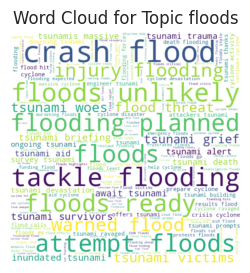

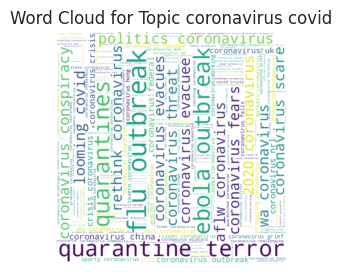

In [33]:
# ===========================
# Visualization
# ===========================

selected_clusters = [7, 10]

# Generate Word Clouds for Selected Topics (for demonstration purposes only)
for cluster in selected_clusters:
    if cluster not in cluster_keywords:  # Skip if cluster doesn't exist
        continue

    words = cluster_keywords[cluster]

    # Create a word cloud for each topic
    word_freq = {word: words.count(word) for word in words}
    wordcloud = WordCloud(width=600, height=600, background_color="white").generate_from_frequencies(word_freq)

    # Plot word cloud
    plt.figure(figsize=(3, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Topic {cluster_labels[cluster]}")
    plt.axis('off')
    # plt.savefig(f"wordcloud_{cluster_labels[cluster]}.pdf", bbox_inches="tight")
    plt.show()

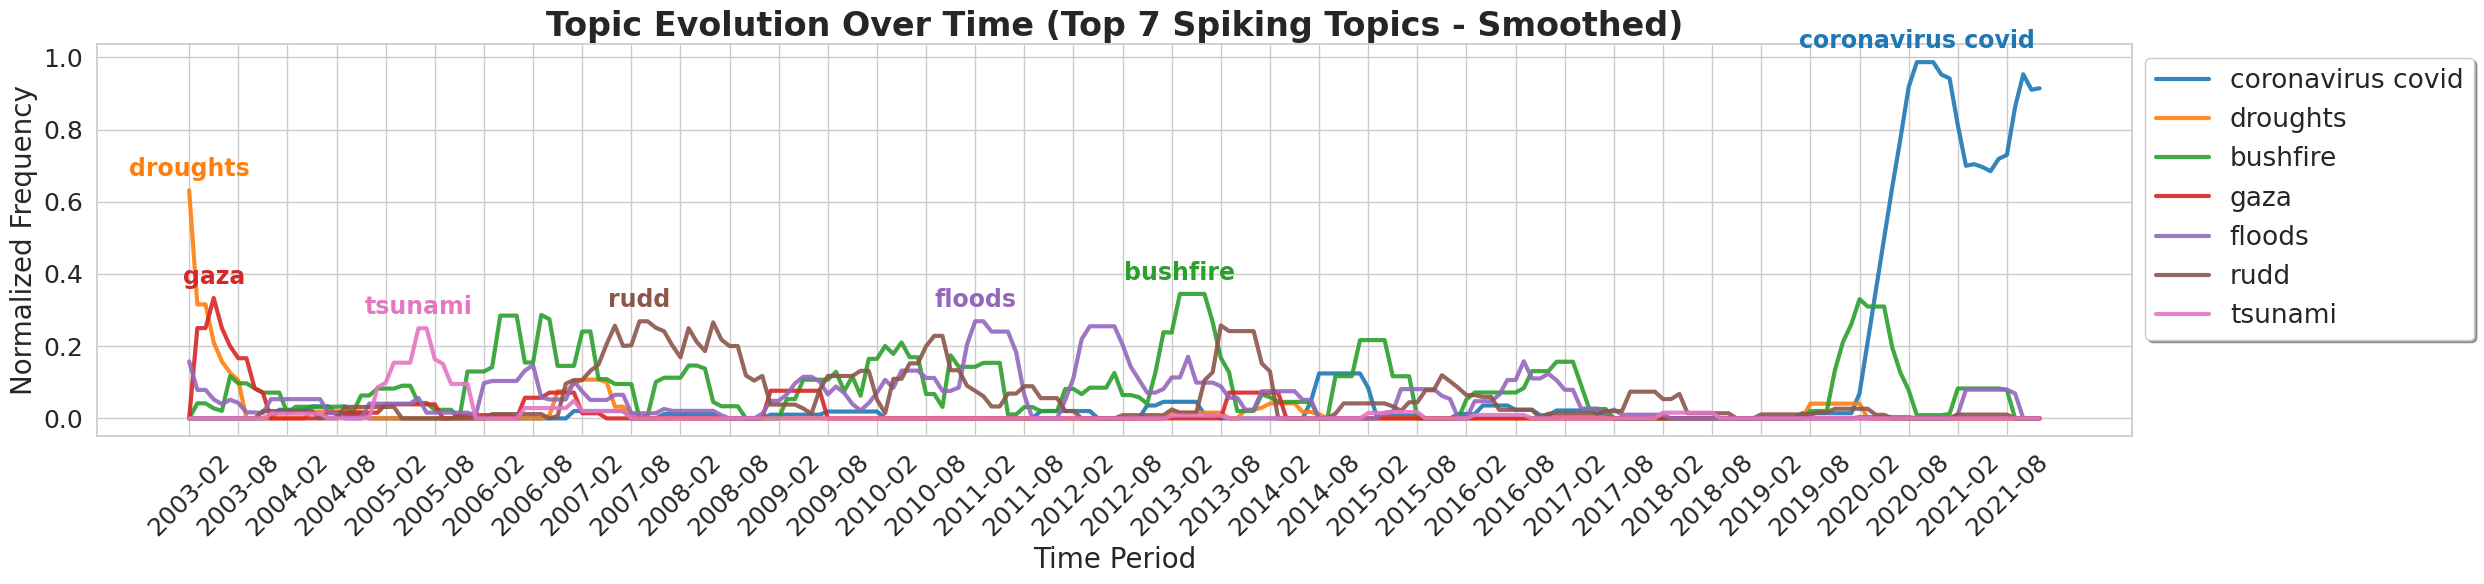

In [23]:
# ===========================
# Select Topics with Major Spikes in Popularity
# ===========================

# Compute percentage change over time
dtm_df_change = dtm_df.pct_change().fillna(0)

# Define spiking topics as those exceeding a 100% increase in any period
spiking_topics = dtm_df_change.columns[(dtm_df_change > 1.0).any()].tolist()

# Select only those topics
dtm_df_filtered = dtm_df[spiking_topics]

# Apply rolling average for smoother trends
dtm_df_smoothed = dtm_df_filtered.rolling(window=7, min_periods=1).mean()

# ===========================
# Visualization: Topic Evolution Over Time (Top 10 Spiking Topics)
# ===========================

sns.set_theme(style="whitegrid")

# Identify the top 7 spiking topics (based on max frequency)
top_spiking_topics = dtm_df_smoothed.max().sort_values(ascending=False).head(7).index.tolist()

plt.figure(figsize=(25, 6), dpi=100)

# Generate color palette for consistency
colors = sns.color_palette("tab10", len(top_spiking_topics))

# Plot each of the top 7 spiking topics with smooth lines
lines = []
for topic, color in zip(top_spiking_topics, colors):
    line, = plt.plot(
        dtm_df_smoothed.index,
        dtm_df_smoothed[topic],
        linewidth=3,
        label=topic,
        alpha=0.9,
        color=color
    )
    lines.append(line)  # Store lines for legend formatting

    max_idx = dtm_df_smoothed[topic].idxmax()
    max_val = dtm_df_smoothed[topic].max()
    plt.annotate(
        topic, (max_idx, max_val),
        textcoords="offset points", xytext=(0,10),
        ha='center', fontsize=17, color=color, fontweight = 'bold'
    )

# Format axis labels and title
plt.xlabel('Time Period', fontsize=20)
plt.ylabel('Normalized Frequency', fontsize=20)
plt.title('Topic Evolution Over Time (Top 7 Spiking Topics - Smoothed)', fontsize=24, fontweight='bold')

# Create a color-matching legend
plt.legend(handles=lines, loc='upper left', bbox_to_anchor=(1, 1), fontsize=19, frameon=True, shadow=True)

# Optimize x-axis tick labels
plt.xticks(
    ticks=dtm_df_smoothed.index[::6],
    labels=dtm_df_smoothed.index[::6],
    rotation=45,
    fontsize=18
)
plt.yticks(fontsize=18)

# Show grid and adjust layout
plt.grid(True)
plt.tight_layout()
plt.savefig('top_7_spiking_topics.pdf', bbox_inches='tight')
plt.show()